In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from numpy import log, exp, sqrt
Nq=2
massinv = np.eye(Nq)
massinv[0,0] = 1.0 / 1
massinv[1,1] = 1.0 / 1

### 1. HMC sampler

#### 1.2 Choose function

In [2]:
## fucntion 1
def logp1(q):
    return -0.5 * (q[0]**2*q[1]**2 + q[0]**2 + q[1]**2 - 8*q[0] - 8*q[1])


def grad1(q):
    grad = np.zeros(2)
    grad[0] = -q[0]*q[1]**2 + q[0] - 4
    grad[1] = -q[1]*q[0]**2 + q[1] - 4   
    return grad


def target_density1(q):
    return np.exp(-0.5 * (q[0]**2*q[1]**2 + q[0]**2 + q[1]**2 - 8*q[0] - 8*q[1]))

## fucntion 2
def logp(q):
    return -0.5 * (q[0]**2 + q[1]**2)


def grad(q):
    grad = np.zeros(2)
    grad[0] = -q[0] 
    grad[1] = -q[1]    
    return grad


def target_density(q):
    return (1 / (2 * np.pi)) * np.exp(-0.5 * (q[0]**2 + q[1]**2))

'''
## fucntion 3: Rosenbrock
#f(x,y) = (a-x)^2 + b(y-x^2)^2
def logp(x, a=1, b=100):
    """Rosenbrock函数"""
    return (a - x[0])**2 + b * (x[1] - x[0]**2)**2

def grad(x, a=1, b=100):
    """Rosenbrock函数的梯度"""
    grad_x = 2 * (a - x[0]) - 4 * b * x[0] * (x[1] - x[0]**2)
    grad_y = 2 * b * (x[1] - x[0]**2)
    return np.array([grad_x, grad_y])

def f(x):
    return logp, grad

def target_density(x):
    return np.exp((a - x[0])**2 + b * (x[1] - x[0]**2)**2)
'''

'\n## fucntion 3: Rosenbrock\n#f(x,y) = (a-x)^2 + b(y-x^2)^2\ndef logp(x, a=1, b=100):\n    """Rosenbrock函数"""\n    return (a - x[0])**2 + b * (x[1] - x[0]**2)**2\n\ndef grad(x, a=1, b=100):\n    """Rosenbrock函数的梯度"""\n    grad_x = 2 * (a - x[0]) - 4 * b * x[0] * (x[1] - x[0]**2)\n    grad_y = 2 * b * (x[1] - x[0]**2)\n    return np.array([grad_x, grad_y])\n\ndef f(x):\n    return logp, grad\n\ndef target_density(x):\n    return np.exp((a - x[0])**2 + b * (x[1] - x[0]**2)**2)\n'

In [11]:
def create_p(Nq):
    p = np.random.normal(loc=0, scale=1.0, size=Nq) 
    return p

def Kp(p):
    '''Compute Kp, as M is identical matrix. '''
    return  0.5 * p.T @ (massinv @p) 


def leapfrog(q, p, e, L, grad):
    #print(grad(q),p)
    for i in range(L):  
        p = p + 1/2 * e * grad(q)
        q = q + e * massinv @ p
        p = p + 1/2 * e * grad(q)
    return q, p

def hmc(q, e, L, n_samples, n_adapt, logp=logp1, grad=grad1):
    samples = []
    for i in range(100000):
        if len(samples) >= n_samples + n_adapt:
            break

        # update q and p
        p = create_p(Nq)
        current_q = q
        current_p = p
        new_q, new_p = leapfrog(current_q, current_p, e, L, grad)
        #print(current_q, new_q)
        # calculate Hamiltonian from potential energy and kinetic energy
        current_U = -logp(current_q)
        current_K = Kp(current_p)

        new_U = -logp(new_q)
        new_K = Kp(new_p)

        # determine whether accept the proposed sample or not
        denergy = current_U - new_U + current_K - new_K
        acceptance_prob = min(0, denergy)
        alpha = np.log(np.random.rand())
        
        if alpha < acceptance_prob:
            #print('! Accept')
            q = new_q
            samples.append(q)
        else:
            #print('Reject')
            q = current_q

    print('Acceptance_rate = {}'.format(len(samples)/i))
    return np.array(samples)[n_adapt:, :]
    #return np.array(samples)

### 2. Visualization

#### 2.1 posterior density distribution and true distribution

In [12]:
def plot_prediction(samples, target_density=target_density1,save_file=None):

    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 2, width_ratios=[2, 2], height_ratios=[2, 2], wspace=0.15, hspace=0.15)

    ax1 = fig.add_subplot(gs[0, 0])
    # generate grids
    x = np.linspace(-2, 6, 100)
    y = np.linspace(-2, 6, 100)
    X, Y = np.meshgrid(x, y)

    # compute the posterior density
    Z = target_density([X,Y])

    # plot samples

    ax1.plot(samples[:, 0], samples[:, 1], 'r+')
    # plot contour
    contour = plt.contour(X, Y, Z, cmap='viridis')
    ax1.clabel(contour, inline=1, fontsize=10)
    ax1.annotate(f'#Samples: {len(samples)}', xy=(5, 5), xytext=(5, 5),
                       ha='center', va='bottom')


    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax2.set_xlabel("x-samples")
    ax2.set_ylabel("density")
    data = samples[:,0]
    mu, sigma = np.mean(data), np.std(data)
    '''
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    gaussian = norm.pdf(x, mu, sigma)
    ax2.plot(x, gaussian, color='red', label='Gaussian Distribution')
    '''
    ax2.hist(data, bins=20,color='k',edgecolor='k',density=True, alpha=0.5)
    ax2.set_title(f'${mu:.2f} \pm {sigma:.2f}$', fontsize=8, loc='right')
    ax2.xaxis.set_tick_params(labelleft=False)


    ax3 = fig.add_subplot(gs[0, 1], sharey=ax1) 
    ax3.set_ylabel("y-samples")
    ax3.set_xlabel("density")
    data = samples[:,1]
    mu, sigma = np.mean(data), np.std(data)
    '''
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    gaussian = norm.pdf(x, mu, sigma)
    ax3.plot(x, gaussian, color='red', label='Gaussian Distribution')
    '''
    ax3.hist(data, bins=20,color='k',edgecolor='k',alpha=0.5,density=True, orientation='horizontal')
    ax3.set_title(f'${mu:.2f} \pm {sigma:.2f}$', fontsize=8, loc='right')
    ax3.yaxis.set_tick_params(labelleft=False)

    ax_blank = fig.add_subplot(gs[1, 1])
    ax_blank.axis('off')

    plt.tight_layout()
    if save_file:
        plt.savefig(save_file)
    else:
        plt.show()


#### 2.2 Convergency speed

1. ACF(Autocorrelation Function) 自相关函数是一个用于评估样本独立性和质量的一个重要工具：\
如果ACF快速下降到零，说明样本之间的独立性较高；
反之，样本之间存在较高的自相关性，样本独立性较低。
2. ACF 可以用来计算有效样本大小（Effective Samples Size, ESS)，其计算公式为 $ESS = M/\tau$，其中M是总样本数，$\tau$是集成自相关时间（integrated autocorrelation time），其定义为: \
   $\tau = 1+2*\sum_{k=1}^{M_{cutoff}} (1- \frac{s}{M}) \rho_k$; $M_{cutoff} = min s$, $s.t. \rho < 0.05$ \
   $\rho = \frac{1}{\sigma^2 (M-s)} \sum_{m=s+1}^{M}(f(\theta^m)-\mu)(f(\theta^{m-s})-\mu)$
   where $\sigma^2$ is the mean of f and $\mu$ is the variance of f

In [13]:
def autocorrelation(chain, lag):
    M = len(chain)
    mean = np.mean(chain)
    var = np.sum((chain - mean) ** 2) / M
    return np.sum((chain[:M-lag] - mean) * (chain[lag:] - mean)) / (M - lag) / var

def autocorrelation_function(chain, max_lag):
    return np.array([autocorrelation(chain, lag) for lag in range(max_lag)])

def integrated_autocorrelation_time(autocorr, M):
    # Use a cutoff when autocorrelation lower than 0.05
    cuttoff_autocorr = autocorr[autocorr > 0.05]
    M_cutoff = len(cuttoff_autocorr)

    sum = 0
    for s in range(M_cutoff):
        sum += cuttoff_autocorr[s] * (1 - s/M)
    
    return 1 + 2 * sum

def effective_sample_size(chain, max_lag):
    M = len(chain)
    autocorr = autocorrelation_function(chain, max_lag)
    tau = integrated_autocorrelation_time(autocorr, M)
    ess = M / tau
    return ess 

# 可视化自相关函数
def plot_autocorrelation(chain, max_lag, label,save_file=None):
    fig = plt.figure(figsize=(10, 10))
    autocorr = autocorrelation_function(chain, max_lag)
    lags = np.arange(max_lag)
    
    plt.figure(figsize=(10, 5))
    plt.stem(lags, autocorr, linefmt='lightblue')
    plt.xlabel('Lag')
    plt.ylabel(f'{label} Autocorrelation')
    plt.title('Autocorrelation Function')
    plt.axhline(y=0.05, color='g', linestyle='--', linewidth=1)
    plt.axhline(y=-0.05, color='g', linestyle='--', linewidth=1)
    plt.grid(True)
    if save_file:
        plt.savefig(save_file)
    else:
        plt.show()

#### 2.3 Log likelihood function, truth value and predicted mean value

In [14]:
def plot_loglikelihood(A, alpha,save_file=None):

    fig = plt.figure(figsize=(10, 10))
    alpha = 0
    # Print Monte-Carlo estimate of alpha.
    print("Mean:  " + str(np.mean(A)))
    per = np.percentile(A, [16, 50, 84])
    print("Alpha = {} (+{} / - {})".format( per[1], per[2] - per[1], per[1] - per[0] ))

    n, b = np.histogram(A, 30)
    x = 0.5 * (b[:-1] + b[1:])
    y = n.astype(float) / n.sum()
    plt.step(x, y, color='b', lw=3, where='mid')


    ylim = plt.ylim()
    plt.vlines(alpha, 0, ylim[1], color='r', lw=3)
    plt.vlines(per, 0., max(y), linestyle='--', color='b', lw=1)
    plt.ylim(ylim)
    plt.xlabel(r'$\alpha$', fontsize=24)
    plt.ylabel(r'$\cal L($Data$;\alpha)$', fontsize=24)
    if save_file:
        plt.savefig(save_file)
    else:
        plt.show()

# Initialization

For each method, we drew 5000 sample safter 1000 burn-in samples.

In [15]:
Nq = 2
q0 = np.random.normal(0, 1, Nq)

# tunning hyperparameters: step size, the number of steps, mass matrix
epsilon = 0.01
L = 20
massinv = np.eye(Nq)
massinv[0,0] = 1.0 / 1
massinv[1,1] = 1.0 / 1

n_samples = 5000
n_adapt = 1000

print("==============Start Sampling=============")
t_start = time.time()

samples = hmc(q0, epsilon, L, n_samples, n_adapt, logp=logp, grad=grad)

t_stop = time.time()
print("Sampling Completed in %0.2f seconds" % (t_stop - t_start))



==============Start Sampling=============
Acceptance_rate = 1.0
Sampling Completed in 0.70 seconds


In [16]:
np.shape(samples)

(5000, 2)

# Visualization

/var/folders/st/h8zl89fn7f7gj0l06p3q5wj40000gn/T/ipykernel_45636/2263969.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Mean:  0.09703270523566876
Alpha = 0.09912065864656586 (+0.8552190872656842 / - 0.8424508307056396)
Mean:  0.09721660045590981
Alpha = 0.11958993194851492 (+0.823314913061133 / - 0.846627499616111)
Effective Sample Size (ESS): 40.830954963288775
Effective Sample Size (ESS): 51.216373466862244


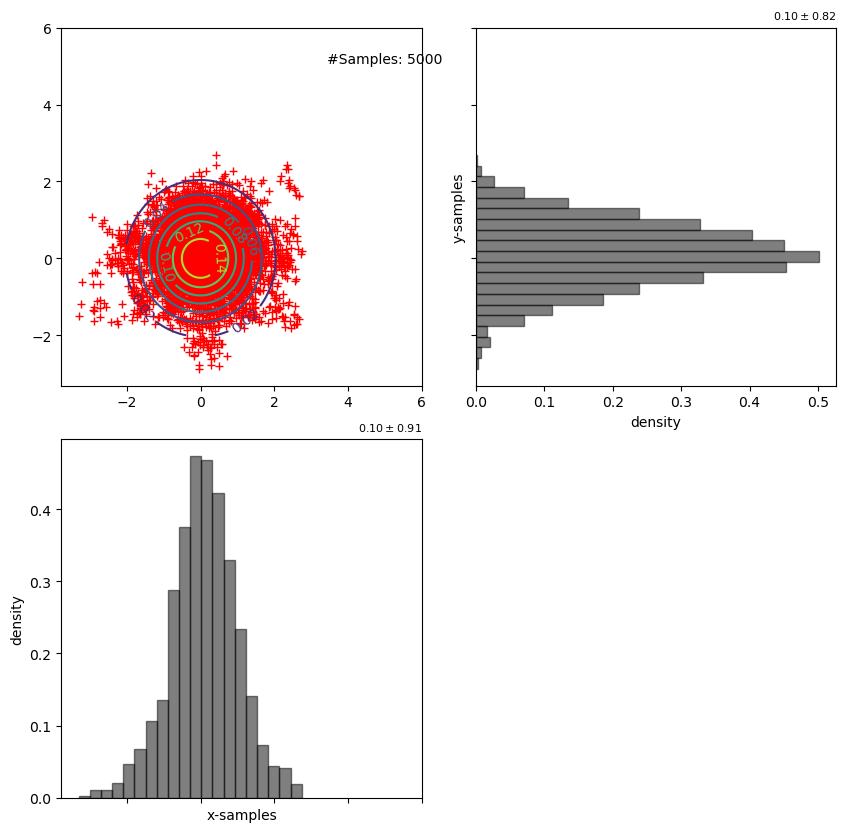

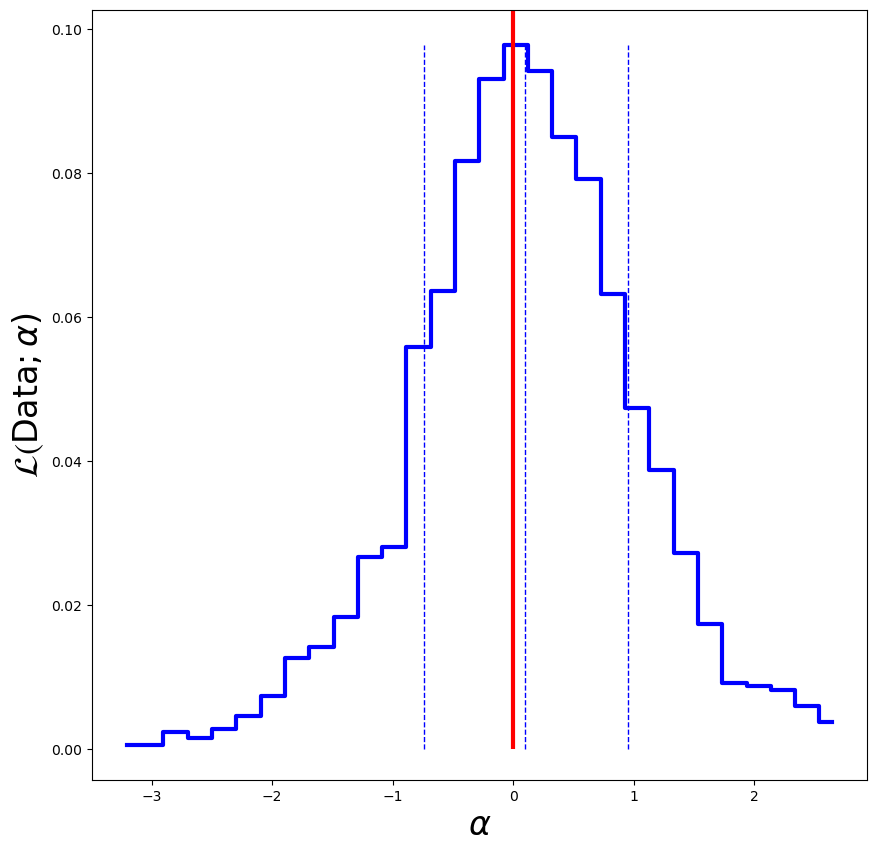

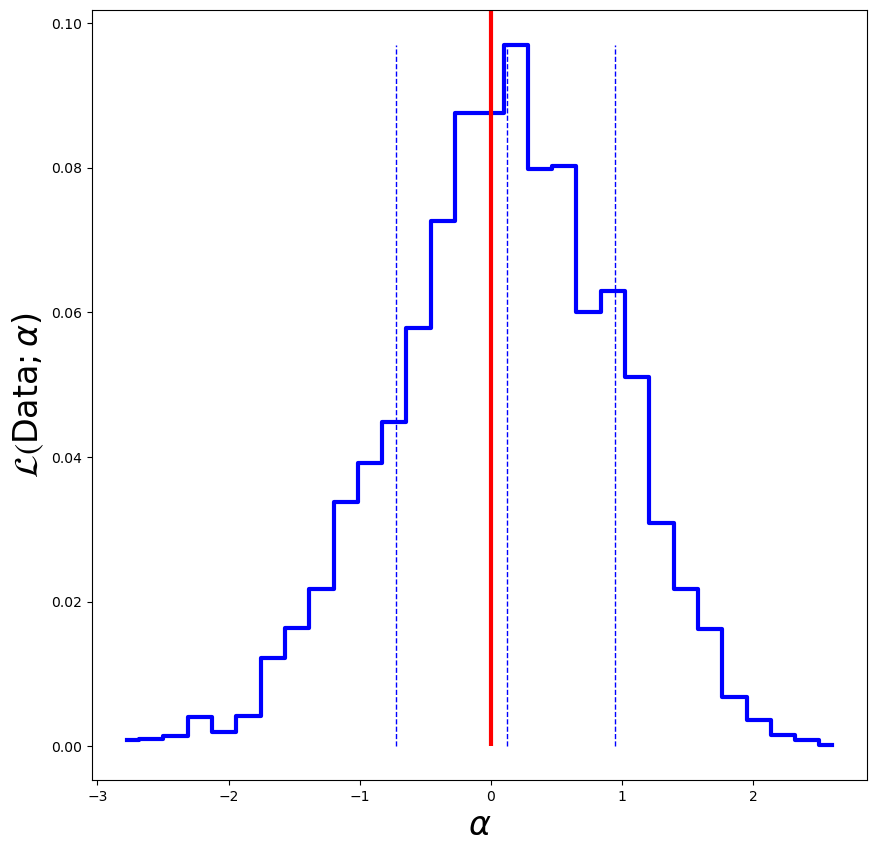

<Figure size 1000x1000 with 0 Axes>

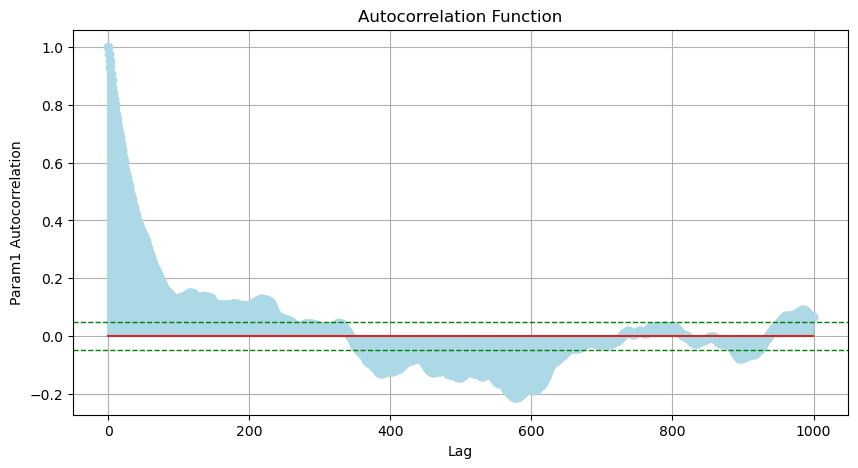

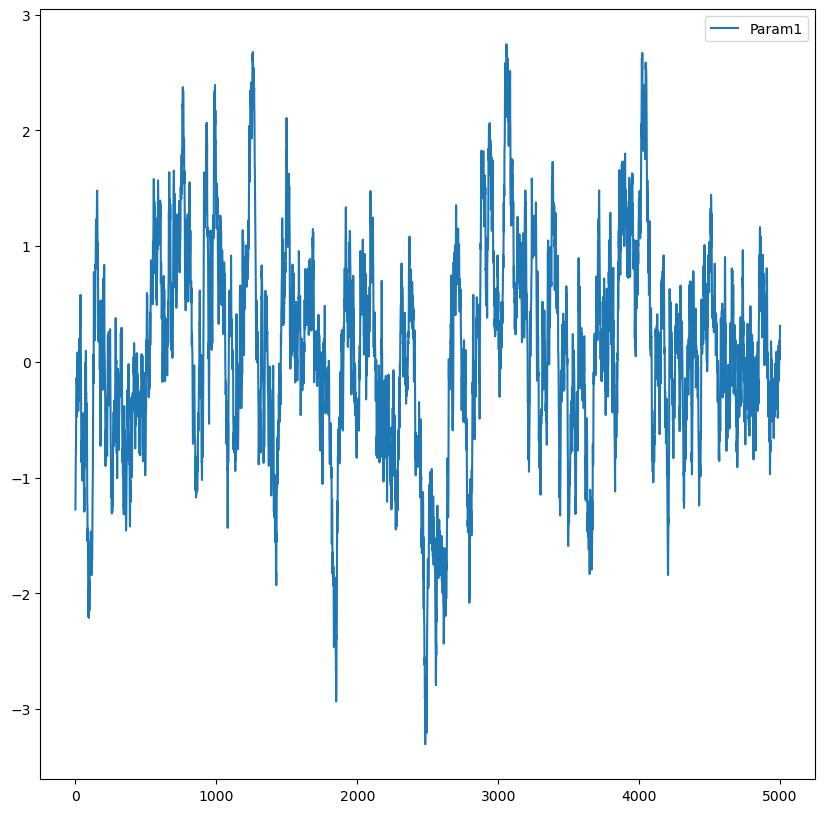

<Figure size 1000x1000 with 0 Axes>

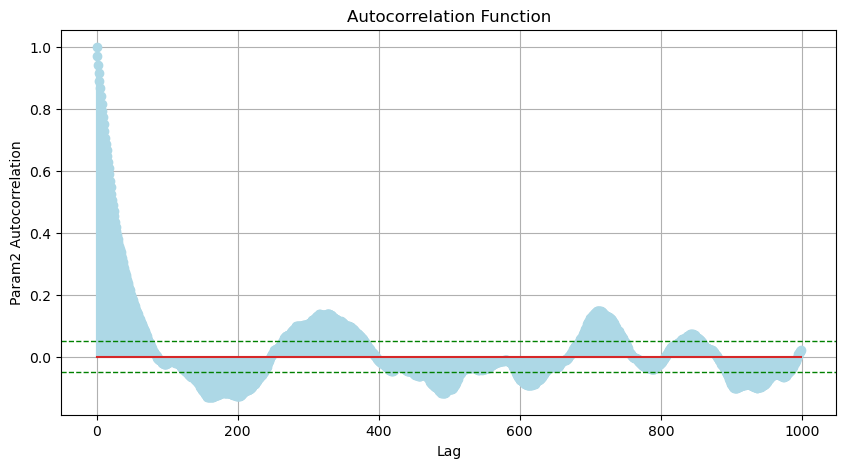

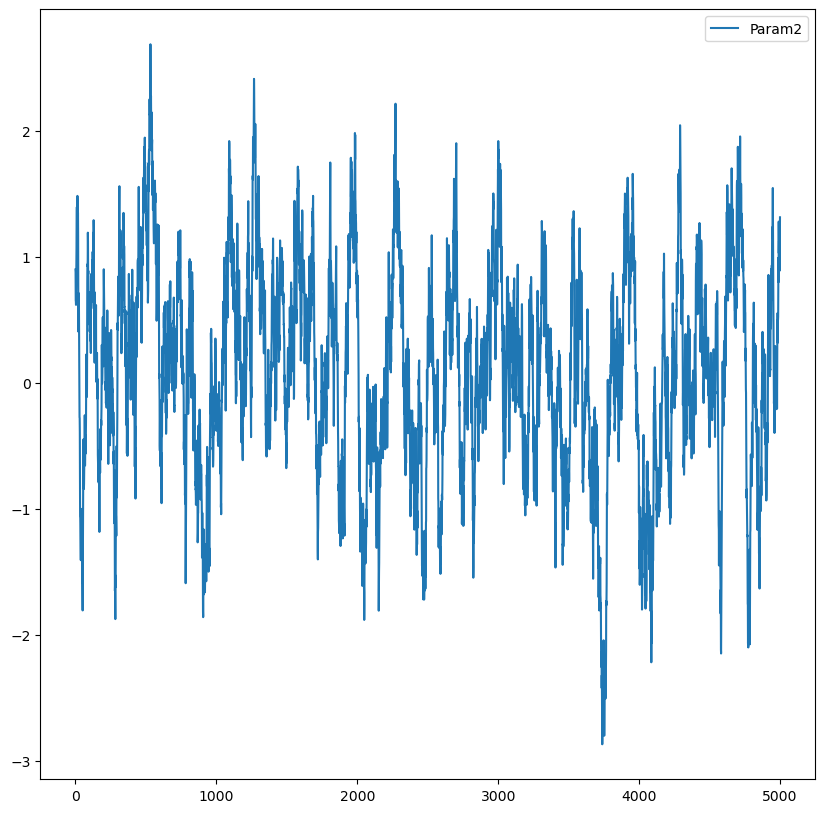

In [17]:

# visualization
plot_prediction(samples, target_density, save_file = '/Users/gangyang/Desktop/figs/1.png')
plot_loglikelihood(samples[:,0], 1, save_file = '/Users/gangyang/Desktop/figs/2.png')

plot_loglikelihood(samples[:,1], 1, save_file = '/Users/gangyang/Desktop/figs/3.png')

# 最大滞后时间
max_lag = 1000

#  parameter 1
data = samples[:,0]
ess = effective_sample_size(data, max_lag)
print("Effective Sample Size (ESS):", ess)
plot_autocorrelation(data, max_lag, label='Param1', save_file = '/Users/gangyang/Desktop/figs/4.png')
fig = plt.figure(figsize=(10, 10))
plt.plot(data, label='Param1')
plt.legend()
plt.savefig('/Users/gangyang/Desktop/figs/5.png')


#  parameter 2
data = samples[:,1]
ess = effective_sample_size(data, max_lag)
print("Effective Sample Size (ESS):", ess)
plot_autocorrelation(data, max_lag, label='Param2', save_file = '/Users/gangyang/Desktop/figs/6.png')

#### sample trace plot for a signle run
fig = plt.figure(figsize=(10, 10))
plt.plot(data, label='Param2')
plt.legend()
plt.savefig('/Users/gangyang/Desktop/figs/7.png')